In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from albumentations.pytorch import ToTensorV2

import albumentations as A
import monai

from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import time
from collections import defaultdict
import copy
import gc

from utils.dataset import EchoDataset
from utils.train import *
from utils.evaluation import *
from utils.optimizer import *
from utils.utils import *

import wandb

In [3]:
### Logging part
import logging
from datetime import datetime
from pytz import timezone
import sys

import random

def log(CFG):
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    def timetz(*args):
        return datetime.now(tz).timetuple()
    tz = timezone('Asia/Seoul')
    logging.Formatter.converter = timetz

    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    # log 출력
    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(formatter)
    logger.addHandler(stream_handler)

    # log를 파일에 출력
    file_handler = logging.FileHandler(os.path.join('saved_model', CFG['version'], f"{CFG['view']}-{CFG['dataset']}-{CFG['backbone']}.log"))
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    logger.info(f"python {' '.join(sys.argv)}")
    logger.info("Timezone: " + str(tz))
    logger.info(f"Training Start")
    return logger


In [4]:
def seed_everything(seed: int=0):    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything()

## ⚙️ Configuration

In [5]:
view2cls_dict = {
    'PLAX': 3,
    'PSAX': 0,
    '2CH': 2,
    '4CH': 2,
}
class cfg:
    def __getitem__(self,key):
        return getattr(self, key)
    def __setitem__(self,key,value):
        return setattr(self, key, value)

    img_size = 256
    view = 'PLAX'
    dataset = 'EchoNetLVH'
    lr = 1e-3
    scheduler = 'LambdaLR'
    reducelr_factor = 0.99
    min_lr = 1e-5
    device = torch.device('mps')
    epochs = 50
    patience = 50
    batch_size = 16

    ##############
    backbone = 'resnet101'
    version = '0.1'
    
CFG = cfg()

os.makedirs(os.path.join('saved_model', CFG['version']), exist_ok=True)

In [6]:

logger = log(CFG)
trace_func = logger.info

2022-10-14 23:09:14,675 - python /opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.8/site-packages/ipykernel_launcher.py -f /Users/kyh/Library/Jupyter/runtime/kernel-6ca72f52-8296-4617-8e1e-0953022cf572.json


2022-10-14 23:09:14,675 - root - INFO - python /opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.8/site-packages/ipykernel_launcher.py -f /Users/kyh/Library/Jupyter/runtime/kernel-6ca72f52-8296-4617-8e1e-0953022cf572.json


2022-10-14 23:09:14,676 - Timezone: Asia/Seoul


2022-10-14 23:09:14,676 - root - INFO - Timezone: Asia/Seoul


2022-10-14 23:09:14,676 - Training Start


2022-10-14 23:09:14,676 - root - INFO - Training Start


In [7]:
dataset_dir = 'output'

In [31]:
def show_lvh(sample):
    image = sample['data'].squeeze().permute(1,2,0).clone()

    plt.figure(figsize=(15,10))
    plt.imshow(image, cmap='gray')
    for coor in sample['label'].reshape(-1, 4):
        coor = coor.squeeze()
        plt.plot((coor[0], coor[2]),
                (coor[1], coor[3]), linewidth=3)
        plt.scatter((coor[0], coor[2]), (coor[1], coor[3]), )
    plt.title(f"id: {sample['id']} \
                shape: {sample['data'].shape}")
    plt.axis('off')
    plt.show()

## 📀 Load Data

In [32]:
from albumentations.core.transforms_interface import ImageOnlyTransform

class MinMaxNormalize(ImageOnlyTransform):
    """
    Min-max normalization
    """
    def apply(self, img, **param):
        # minmax normalize
        img = (img - img.min()) / (img.max() - img.min())
        return img


In [39]:
train_ts = A.Compose([
    A.Resize(375, 500),
    MinMaxNormalize(p=1),
    A.HorizontalFlip(p=.5),
    A.VerticalFlip(p=.5),
    # A.OneOf([
    #     A.MedianBlur(blur_limit=3, p=0.1),
    #     A.MotionBlur(p=0.2),
    # ], p=0.2),
    # A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2,
    #                    rotate_limit=10, p=0.2),
    # A.OneOf([
    #     A.OpticalDistortion(p=0.3),
    # ], p=0.2),
    # A.OneOf([
    #     A.GaussNoise(p=0.2),
    #     A.MultiplicativeNoise(p=0.2),
    # ], p=0.2),
    # A.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=0,
    #                      val_shift_limit=0.1, p=0.3),
    # ToTensorV2(),
    
],
keypoint_params=A.KeypointParams(format='xy')
)
test_ts = A.Compose([
                    A.Resize(375, 500),
                    MinMaxNormalize(p=1),
                    # ToTensorV2(),
                    ])


In [40]:
ds = EchoDataset(root=dataset_dir, split='train', transforms=train_ts)
dl = DataLoader(ds, batch_size=1, shuffle=False, )
s = dl.__iter__().__next__()
s

{'data': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 'label': tensor([[235.3281, 166.5039, 229.4688, 149.9023, 271.4609, 265.6250, 265.6016,
          248.0469, 265.6016, 248.0469, 235.3281, 166.5039]]),
 'id': [

In [41]:
sample['data'].shape

torch.Size([1, 3, 375, 500])

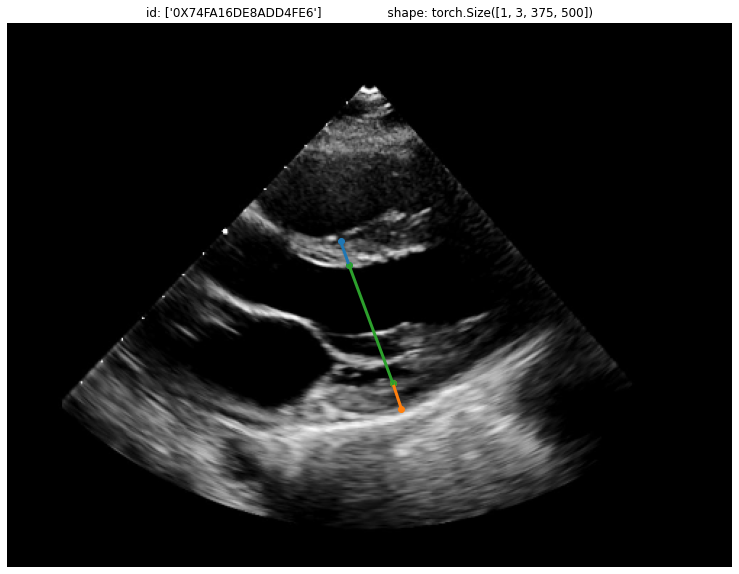

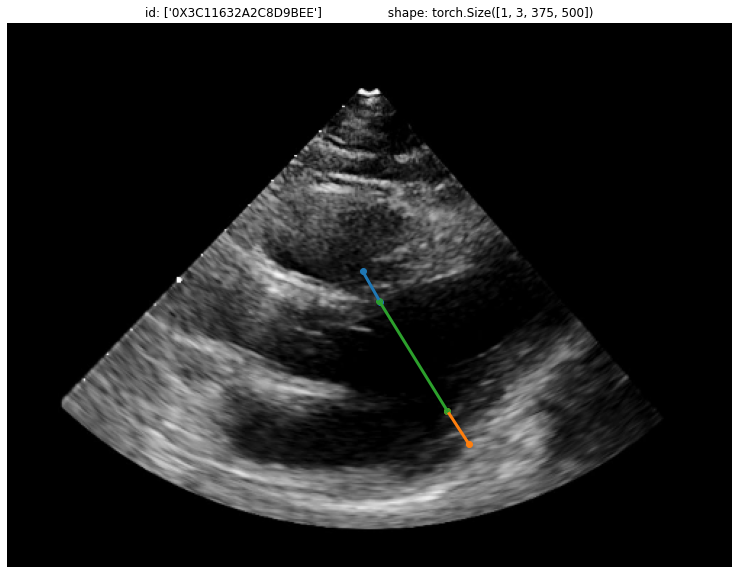

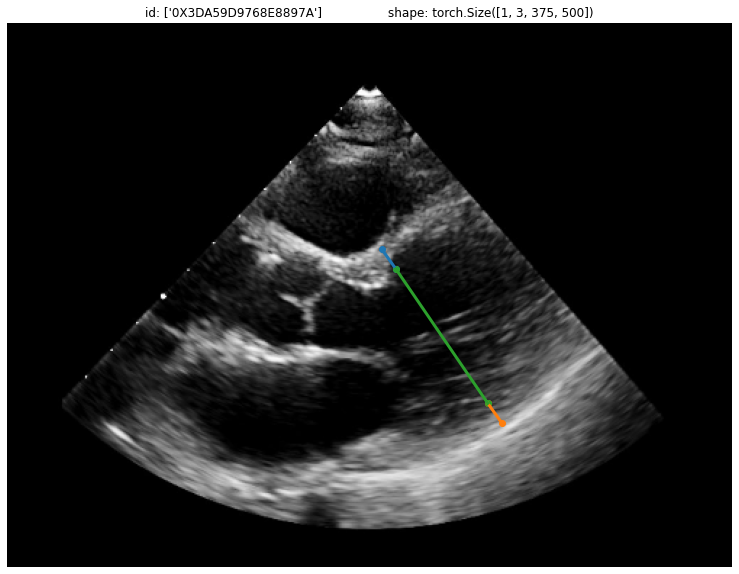

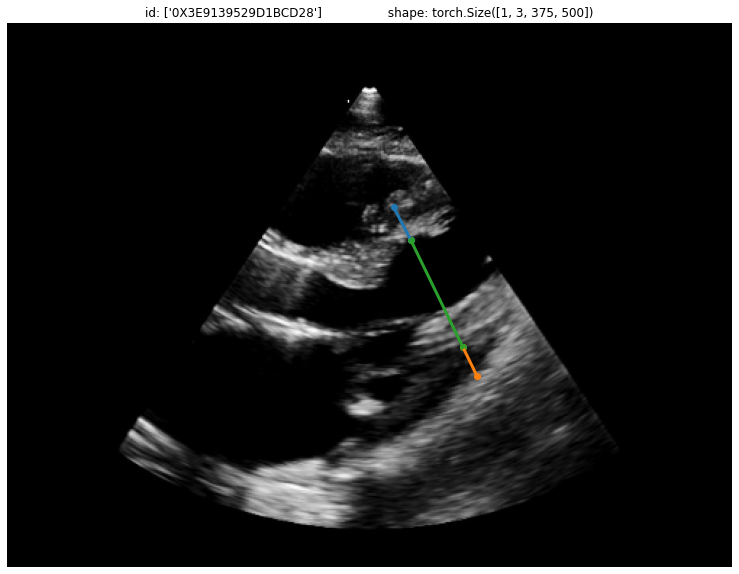

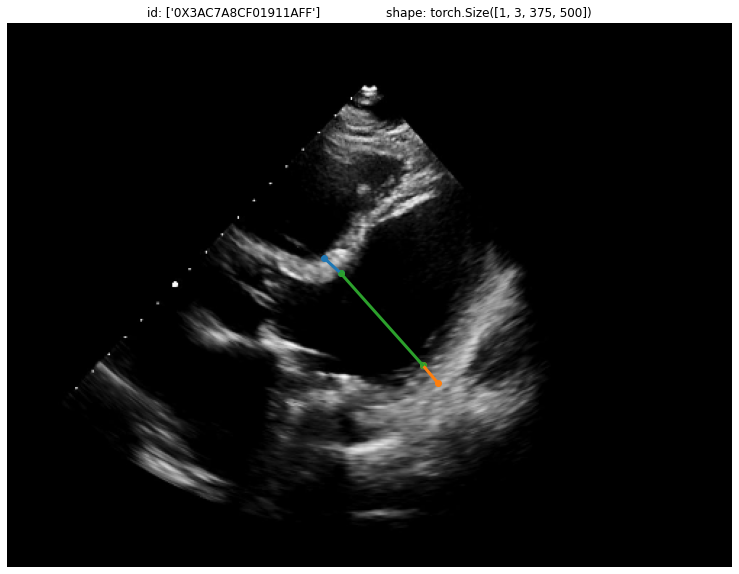

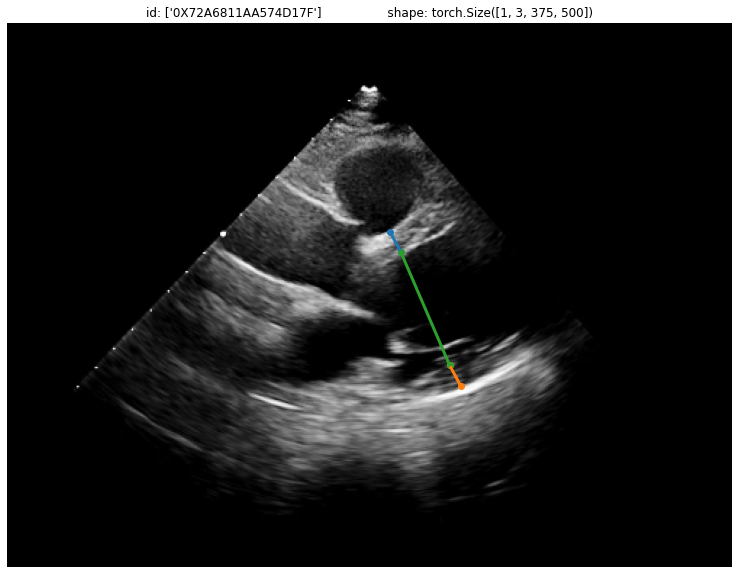

In [42]:
for i, sample in enumerate(dl):
    show_lvh(sample)
    if i == 5:
        break

In [93]:
train_ds = EchoDataset(root=dataset_dir, split='train', transforms=train_ts)
valid_ds = EchoDataset(root=dataset_dir, split='val', transforms=test_ts)

train_dl = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=CFG.batch_size//2, shuffle=False)

## 🧮 Load Model

In [14]:
import torch.nn.functional as F
class Model_resnet(nn.Module):
    def __init__(self, backbone, in_channels, out_channels, ):
        super().__init__()
        # self.input = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=1)
        for param in backbone.parameters():
            param.requires_grad = True
        self.backbone = nn.Sequential(
                                      *(list(backbone.children())[:-2]),
                                      )   
        # resnet34: 512
        # resnet101: 2048    
        self.fc = nn.Linear(in_features=2048, out_features=out_channels*2*2, bias=True)
    def forward(self, x):
        # x = self.input(x)
        out = self.backbone(x)
        # out = F.relu(out, inplace=False)
        out = F.adaptive_avg_pool2d(out, output_size=(1,1)).view(x.size(0), -1)
        out = self.fc(out)
        # out = F.relu(out)
        return out
    

In [15]:
import torch.nn.functional as F
class Model(nn.Module):
    def __init__(self, backbone, in_channels, out_channels, ):
        super().__init__()
        # self.input = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=1)
        for param in backbone.features.parameters():
            param.requires_grad = True
        self.backbone = backbone.features
        # self.backbone = nn.Sequential(
        #                               *(list(backbone.children())[:-1]),
        #                               )   
        self.fc1 = nn.Linear(in_features=1024, out_features=512, bias=True)
        self.fc2 = nn.Linear(in_features=512, out_features=out_channels*2*2, bias=True)
    def forward(self, x):
        # x = self.input(x)
        out = self.backbone(x)
        # out = F.relu(out, inplace=False)
        out = F.adaptive_avg_pool2d(out, output_size=(1,1)).view(x.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        # out = F.relu(out)
        return out
    

In [16]:
# model = Model(
#                 torchvision.models.densenet121(weights=False),
#                 1,
#                 3
#             )
# model(torch.zeros(2,3,256,256)).shape

## 🤖 Run Model

In [17]:
from utils.train import train_one_epoch, valid_one_epoch

In [18]:

def run_training(model, train_dl, val_dl, optimizer, scheduler, criterion, CFG, wandb):
    """
    모델, 데이터를 받아 학습/검증 수행후 결과에 대해 출력 및 모델 저장
    """
    device = CFG['device']
    num_epochs = CFG['epochs']
    start = time.time()
    early_stopping = EarlyStopping(patience=CFG['patience'], verbose=True, trace_func=trace_func)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_mde = np.inf
    best_epoch = -1
    history = defaultdict(list)
    # 에폭만큼 학습 수행
    for epoch in range(1, num_epochs+1):
        gc.collect()
        # 에폭 단위 학습 수행
        train_loss, train_mde = train_one_epoch(model=model, dataloader=train_dl, optimizer=optimizer, scheduler=scheduler, device=device, criterion=criterion, CFG=CFG)
        # 에폭 단위 검증 수행
        val_loss, val_mde = valid_one_epoch(model=model, dataloader=val_dl, device=device, criterion=criterion, CFG=CFG)
        early_stopping(val_loss, model)

        history['Train Loss'].append(train_loss)
        history['Train MDE'].append(train_mde)
        history['Valid Loss'].append(val_loss)
        history['Valid MDE'].append(val_mde)
        
        wandb.log({"Train Loss": train_loss, 
            "Train MDE": train_mde,
            "Valid Loss": val_loss,
            "Valid MDE": val_mde,
            "LR":scheduler.get_last_lr()[0]})

        trace_func(f"[Epoch {epoch}/{CFG['epochs']}: Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}, Train MDE: {train_mde:.5f}, Val MDE: {val_mde:.5f}")
        
        if scheduler is not None:
            scheduler.step()
        # validation MDE가 개선이 된 경우 모델을 저장
        if val_mde <= best_mde:
            trace_func(f"Valid Score Improved ({best_mde:.4f} ---> {val_mde:.4f})")
            best_mde = val_mde
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            
            wandb.run.summary['Best MDE'] = best_mde
            wandb.run.summary['Best Epoch'] = best_epoch

            model_name = f"best_epoch-{CFG['view']}-{CFG['dataset']}-{CFG['backbone']}.pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict':optimizer.state_dict(),
                'loss': val_loss
                }, 
                os.path.join(f"saved_model", CFG['version'], model_name))

            trace_func(f"Model Saved")
        if early_stopping.early_stop:
            trace_func("Early stopping")
            break

    model_name = f"last_epoch-{CFG['view']}-{CFG['dataset']}-{CFG['backbone']}.pth"
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict':optimizer.state_dict(),
                'loss': val_loss
                }, 
                os.path.join(f"saved_model", CFG['version'], model_name))
    
    end = time.time()
    time_elapsed = end-start
    trace_func("Trianing complete in {:.0f}h {:.0f}m {:.0f}s".format(time_elapsed//3600, (time_elapsed%3600)//60, (time_elapsed%3600)%60))
    trace_func("Best Val MDE: {:.4f}".format(best_mde))

    model.load_state_dict(best_model_wts)

    return model, history

In [19]:
model = Model_resnet(
                torchvision.models.resnet101(weights=None),
                1,
                3
            )
optimizer = torch.optim.Adam(params=model.parameters(), lr=CFG.lr)
criterion = nn.MSELoss()

In [20]:
run = wandb.init(project='2022KOHI_keypoint_detection',
                group=CFG['version'],
                name= f"View-{CFG['view']}|Dataset-{CFG['dataset']}|Backbone-{CFG['backbone']}",
                entity='kyh',
                # config={k:v for k, v in CFG.items() if '__' not in k},
                )

model, hist = run_training(model=model.to(CFG['device']),
             train_dl=train_dl, 
             val_dl=valid_dl, 
             optimizer=optimizer, 
             scheduler=fetch_scheduler(CFG, optimizer), 
             criterion=criterion, 
             CFG=CFG,
             wandb=wandb)
wandb.run.finish()

2022-10-14 20:30:53,293 - Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


2022-10-14 20:30:53,293 - wandb.jupyter - ERROR - Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kyh. Use `wandb login --relogin` to force relogin


Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.04it/s, valid_MDE=122482.2404, valid_loss=32026.0907]

2022-10-14 20:31:40,577 - Validation loss decreased (inf --> 32026.090708))#.  Saving model ...



2022-10-14 20:31:40,577 - root - INFO - Validation loss decreased (inf --> 32026.090708))#.  Saving model ...


2022-10-14 20:31:40,579 - [Epoch 1/50: Train Loss: 41942.44615, Val Loss: 32026.09071, Train MDE: 151305.74585, Val MDE: 122482.24041


2022-10-14 20:31:40,579 - root - INFO - [Epoch 1/50: Train Loss: 41942.44615, Val Loss: 32026.09071, Train MDE: 151305.74585, Val MDE: 122482.24041


Adjusting learning rate of group 0 to 9.9000e-04.
2022-10-14 20:31:40,580 - Valid Score Improved (inf ---> 122482.2404)


2022-10-14 20:31:40,580 - root - INFO - Valid Score Improved (inf ---> 122482.2404)


2022-10-14 20:31:44,150 - Model Saved


2022-10-14 20:31:44,150 - root - INFO - Model Saved
Valid : 100%|██████████| 15/15 [00:04<00:00,  3.01it/s, valid_MDE=57279.1497, valid_loss=14960.1262]

2022-10-14 20:32:23,052 - Validation loss decreased (32026.090708 --> 14960.126158))#.  Saving model ...



2022-10-14 20:32:23,052 - root - INFO - Validation loss decreased (32026.090708 --> 14960.126158))#.  Saving model ...


2022-10-14 20:32:23,072 - [Epoch 2/50: Train Loss: 21910.45865, Val Loss: 14960.12616, Train MDE: 78187.43024, Val MDE: 57279.14971


2022-10-14 20:32:23,072 - root - INFO - [Epoch 2/50: Train Loss: 21910.45865, Val Loss: 14960.12616, Train MDE: 78187.43024, Val MDE: 57279.14971


Adjusting learning rate of group 0 to 9.8010e-04.
2022-10-14 20:32:23,074 - Valid Score Improved (122482.2404 ---> 57279.1497)


2022-10-14 20:32:23,074 - root - INFO - Valid Score Improved (122482.2404 ---> 57279.1497)


2022-10-14 20:32:26,696 - Model Saved


2022-10-14 20:32:26,696 - root - INFO - Model Saved
Valid : 100%|██████████| 15/15 [00:04<00:00,  3.11it/s, valid_MDE=8343.0288, valid_loss=2203.4075]

2022-10-14 20:33:05,015 - Validation loss decreased (14960.126158 --> 2203.407490))#.  Saving model ...



2022-10-14 20:33:05,015 - root - INFO - Validation loss decreased (14960.126158 --> 2203.407490))#.  Saving model ...


2022-10-14 20:33:05,017 - [Epoch 3/50: Train Loss: 8470.46940, Val Loss: 2203.40749, Train MDE: 30413.31787, Val MDE: 8343.02876


2022-10-14 20:33:05,017 - root - INFO - [Epoch 3/50: Train Loss: 8470.46940, Val Loss: 2203.40749, Train MDE: 30413.31787, Val MDE: 8343.02876


Adjusting learning rate of group 0 to 9.7030e-04.
2022-10-14 20:33:05,018 - Valid Score Improved (57279.1497 ---> 8343.0288)


2022-10-14 20:33:05,018 - root - INFO - Valid Score Improved (57279.1497 ---> 8343.0288)


2022-10-14 20:33:08,573 - Model Saved


2022-10-14 20:33:08,573 - root - INFO - Model Saved
Valid : 100%|██████████| 15/15 [00:04<00:00,  3.11it/s, valid_MDE=4490.9823, valid_loss=1161.1289]

2022-10-14 20:33:46,387 - Validation loss decreased (2203.407490 --> 1161.128876))#.  Saving model ...



2022-10-14 20:33:46,387 - root - INFO - Validation loss decreased (2203.407490 --> 1161.128876))#.  Saving model ...


2022-10-14 20:33:46,390 - [Epoch 4/50: Train Loss: 2528.39530, Val Loss: 1161.12888, Train MDE: 9049.60219, Val MDE: 4490.98230


2022-10-14 20:33:46,390 - root - INFO - [Epoch 4/50: Train Loss: 2528.39530, Val Loss: 1161.12888, Train MDE: 9049.60219, Val MDE: 4490.98230


Adjusting learning rate of group 0 to 9.6060e-04.
2022-10-14 20:33:46,392 - Valid Score Improved (8343.0288 ---> 4490.9823)


2022-10-14 20:33:46,392 - root - INFO - Valid Score Improved (8343.0288 ---> 4490.9823)


2022-10-14 20:33:49,629 - Model Saved


2022-10-14 20:33:49,629 - root - INFO - Model Saved
Valid : 100%|██████████| 15/15 [00:04<00:00,  3.14it/s, valid_MDE=2019.9447, valid_loss=531.3021]

2022-10-14 20:34:26,925 - Validation loss decreased (1161.128876 --> 531.302091))#.  Saving model ...



2022-10-14 20:34:26,925 - root - INFO - Validation loss decreased (1161.128876 --> 531.302091))#.  Saving model ...


2022-10-14 20:34:26,928 - [Epoch 5/50: Train Loss: 751.48279, Val Loss: 531.30209, Train MDE: 2677.84502, Val MDE: 2019.94469


2022-10-14 20:34:26,928 - root - INFO - [Epoch 5/50: Train Loss: 751.48279, Val Loss: 531.30209, Train MDE: 2677.84502, Val MDE: 2019.94469


Adjusting learning rate of group 0 to 9.5099e-04.
2022-10-14 20:34:26,930 - Valid Score Improved (4490.9823 ---> 2019.9447)


2022-10-14 20:34:26,930 - root - INFO - Valid Score Improved (4490.9823 ---> 2019.9447)


2022-10-14 20:34:30,153 - Model Saved


2022-10-14 20:34:30,153 - root - INFO - Model Saved
Valid : 100%|██████████| 15/15 [00:04<00:00,  3.03it/s, valid_MDE=2455.7139, valid_loss=631.9102]

2022-10-14 20:35:07,663 - EarlyStopping counter: 1 out of 50



2022-10-14 20:35:07,663 - root - INFO - EarlyStopping counter: 1 out of 50


2022-10-14 20:35:07,665 - [Epoch 6/50: Train Loss: 445.81685, Val Loss: 631.91017, Train MDE: 1589.59201, Val MDE: 2455.71386


2022-10-14 20:35:07,665 - root - INFO - [Epoch 6/50: Train Loss: 445.81685, Val Loss: 631.91017, Train MDE: 1589.59201, Val MDE: 2455.71386
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.4148e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.14it/s, valid_MDE=2912.5347, valid_loss=748.1996]

2022-10-14 20:35:45,011 - EarlyStopping counter: 2 out of 50



2022-10-14 20:35:45,011 - root - INFO - EarlyStopping counter: 2 out of 50


2022-10-14 20:35:45,015 - [Epoch 7/50: Train Loss: 394.32035, Val Loss: 748.19963, Train MDE: 1407.05694, Val MDE: 2912.53466


2022-10-14 20:35:45,015 - root - INFO - [Epoch 7/50: Train Loss: 394.32035, Val Loss: 748.19963, Train MDE: 1407.05694, Val MDE: 2912.53466
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.3207e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.07it/s, valid_MDE=3374.4270, valid_loss=864.5567]

2022-10-14 20:36:22,908 - EarlyStopping counter: 3 out of 50



2022-10-14 20:36:22,908 - root - INFO - EarlyStopping counter: 3 out of 50


2022-10-14 20:36:22,928 - [Epoch 8/50: Train Loss: 385.32386, Val Loss: 864.55668, Train MDE: 1377.15347, Val MDE: 3374.42699


2022-10-14 20:36:22,928 - root - INFO - [Epoch 8/50: Train Loss: 385.32386, Val Loss: 864.55668, Train MDE: 1377.15347, Val MDE: 3374.42699
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.2274e-04.


Valid : 100%|██████████| 15/15 [00:05<00:00,  2.89it/s, valid_MDE=1708.9661, valid_loss=454.8680]

2022-10-14 20:37:01,401 - Validation loss decreased (531.302091 --> 454.868028))#.  Saving model ...



2022-10-14 20:37:01,401 - root - INFO - Validation loss decreased (531.302091 --> 454.868028))#.  Saving model ...


2022-10-14 20:37:01,419 - [Epoch 9/50: Train Loss: 398.02716, Val Loss: 454.86803, Train MDE: 1410.15799, Val MDE: 1708.96608


2022-10-14 20:37:01,419 - root - INFO - [Epoch 9/50: Train Loss: 398.02716, Val Loss: 454.86803, Train MDE: 1410.15799, Val MDE: 1708.96608


Adjusting learning rate of group 0 to 9.1352e-04.
2022-10-14 20:37:01,420 - Valid Score Improved (2019.9447 ---> 1708.9661)


2022-10-14 20:37:01,420 - root - INFO - Valid Score Improved (2019.9447 ---> 1708.9661)


2022-10-14 20:37:05,224 - Model Saved


2022-10-14 20:37:05,224 - root - INFO - Model Saved
Valid : 100%|██████████| 15/15 [00:05<00:00,  2.96it/s, valid_MDE=5954.8820, valid_loss=1589.0822]

2022-10-14 20:37:44,074 - EarlyStopping counter: 1 out of 50



2022-10-14 20:37:44,074 - root - INFO - EarlyStopping counter: 1 out of 50


2022-10-14 20:37:44,079 - [Epoch 10/50: Train Loss: 388.03692, Val Loss: 1589.08222, Train MDE: 1373.58824, Val MDE: 5954.88201


2022-10-14 20:37:44,079 - root - INFO - [Epoch 10/50: Train Loss: 388.03692, Val Loss: 1589.08222, Train MDE: 1373.58824, Val MDE: 5954.88201
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.0438e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.08it/s, valid_MDE=2957.8916, valid_loss=787.4180]

2022-10-14 20:38:21,336 - EarlyStopping counter: 2 out of 50



2022-10-14 20:38:21,336 - root - INFO - EarlyStopping counter: 2 out of 50


2022-10-14 20:38:21,349 - [Epoch 11/50: Train Loss: 374.20792, Val Loss: 787.41803, Train MDE: 1328.01094, Val MDE: 2957.89159


2022-10-14 20:38:21,349 - root - INFO - [Epoch 11/50: Train Loss: 374.20792, Val Loss: 787.41803, Train MDE: 1328.01094, Val MDE: 2957.89159
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.9534e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.08it/s, valid_MDE=1338.3068, valid_loss=349.0636]

2022-10-14 20:38:58,860 - Validation loss decreased (454.868028 --> 349.063627))#.  Saving model ...



2022-10-14 20:38:58,860 - root - INFO - Validation loss decreased (454.868028 --> 349.063627))#.  Saving model ...


2022-10-14 20:38:58,863 - [Epoch 12/50: Train Loss: 367.11712, Val Loss: 349.06363, Train MDE: 1314.82843, Val MDE: 1338.30678


2022-10-14 20:38:58,863 - root - INFO - [Epoch 12/50: Train Loss: 367.11712, Val Loss: 349.06363, Train MDE: 1314.82843, Val MDE: 1338.30678


Adjusting learning rate of group 0 to 8.8638e-04.
2022-10-14 20:38:58,864 - Valid Score Improved (1708.9661 ---> 1338.3068)


2022-10-14 20:38:58,864 - root - INFO - Valid Score Improved (1708.9661 ---> 1338.3068)


2022-10-14 20:39:02,182 - Model Saved


2022-10-14 20:39:02,182 - root - INFO - Model Saved
Valid : 100%|██████████| 15/15 [00:05<00:00,  2.89it/s, valid_MDE=1448.6217, valid_loss=384.0747]

2022-10-14 20:39:40,657 - EarlyStopping counter: 1 out of 50



2022-10-14 20:39:40,657 - root - INFO - EarlyStopping counter: 1 out of 50


2022-10-14 20:39:40,668 - [Epoch 13/50: Train Loss: 358.48661, Val Loss: 384.07472, Train MDE: 1280.17873, Val MDE: 1448.62168


2022-10-14 20:39:40,668 - root - INFO - [Epoch 13/50: Train Loss: 358.48661, Val Loss: 384.07472, Train MDE: 1280.17873, Val MDE: 1448.62168
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.7752e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.14it/s, valid_MDE=1476.7404, valid_loss=389.4502]

2022-10-14 20:40:18,204 - EarlyStopping counter: 2 out of 50



2022-10-14 20:40:18,204 - root - INFO - EarlyStopping counter: 2 out of 50


2022-10-14 20:40:18,207 - [Epoch 14/50: Train Loss: 355.51249, Val Loss: 389.45020, Train MDE: 1282.68363, Val MDE: 1476.74041


2022-10-14 20:40:18,207 - root - INFO - [Epoch 14/50: Train Loss: 355.51249, Val Loss: 389.45020, Train MDE: 1282.68363, Val MDE: 1476.74041
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.6875e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.13it/s, valid_MDE=2209.2330, valid_loss=588.5302]

2022-10-14 20:40:56,441 - EarlyStopping counter: 3 out of 50



2022-10-14 20:40:56,441 - root - INFO - EarlyStopping counter: 3 out of 50


2022-10-14 20:40:56,445 - [Epoch 15/50: Train Loss: 350.44313, Val Loss: 588.53015, Train MDE: 1259.36501, Val MDE: 2209.23304


2022-10-14 20:40:56,445 - root - INFO - [Epoch 15/50: Train Loss: 350.44313, Val Loss: 588.53015, Train MDE: 1259.36501, Val MDE: 2209.23304
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.6006e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.04it/s, valid_MDE=1432.8355, valid_loss=376.4618]

2022-10-14 20:41:34,251 - EarlyStopping counter: 4 out of 50



2022-10-14 20:41:34,251 - root - INFO - EarlyStopping counter: 4 out of 50


2022-10-14 20:41:34,253 - [Epoch 16/50: Train Loss: 346.46890, Val Loss: 376.46184, Train MDE: 1254.04261, Val MDE: 1432.83555


2022-10-14 20:41:34,253 - root - INFO - [Epoch 16/50: Train Loss: 346.46890, Val Loss: 376.46184, Train MDE: 1254.04261, Val MDE: 1432.83555
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.5146e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.04it/s, valid_MDE=2939.5922, valid_loss=761.8282]

2022-10-14 20:42:15,756 - EarlyStopping counter: 5 out of 50



2022-10-14 20:42:15,756 - root - INFO - EarlyStopping counter: 5 out of 50


2022-10-14 20:42:15,759 - [Epoch 17/50: Train Loss: 336.74095, Val Loss: 761.82821, Train MDE: 1218.05920, Val MDE: 2939.59218


2022-10-14 20:42:15,759 - root - INFO - [Epoch 17/50: Train Loss: 336.74095, Val Loss: 761.82821, Train MDE: 1218.05920, Val MDE: 2939.59218
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.4294e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.10it/s, valid_MDE=2028.9963, valid_loss=533.6182]

2022-10-14 20:42:53,547 - EarlyStopping counter: 6 out of 50



2022-10-14 20:42:53,547 - root - INFO - EarlyStopping counter: 6 out of 50


2022-10-14 20:42:53,550 - [Epoch 18/50: Train Loss: 335.76513, Val Loss: 533.61825, Train MDE: 1217.89178, Val MDE: 2028.99631


2022-10-14 20:42:53,550 - root - INFO - [Epoch 18/50: Train Loss: 335.76513, Val Loss: 533.61825, Train MDE: 1217.89178, Val MDE: 2028.99631
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.3451e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.17it/s, valid_MDE=3866.7788, valid_loss=1022.6081]

2022-10-14 20:43:31,044 - EarlyStopping counter: 7 out of 50



2022-10-14 20:43:31,044 - root - INFO - EarlyStopping counter: 7 out of 50


2022-10-14 20:43:31,047 - [Epoch 19/50: Train Loss: 313.47088, Val Loss: 1022.60813, Train MDE: 1133.75679, Val MDE: 3866.77876


2022-10-14 20:43:31,047 - root - INFO - [Epoch 19/50: Train Loss: 313.47088, Val Loss: 1022.60813, Train MDE: 1133.75679, Val MDE: 3866.77876
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.2617e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.16it/s, valid_MDE=1491.4558, valid_loss=392.6988]

2022-10-14 20:44:07,718 - EarlyStopping counter: 8 out of 50



2022-10-14 20:44:07,718 - root - INFO - EarlyStopping counter: 8 out of 50


2022-10-14 20:44:07,720 - [Epoch 20/50: Train Loss: 314.28141, Val Loss: 392.69877, Train MDE: 1143.67345, Val MDE: 1491.45575


2022-10-14 20:44:07,720 - root - INFO - [Epoch 20/50: Train Loss: 314.28141, Val Loss: 392.69877, Train MDE: 1143.67345, Val MDE: 1491.45575
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.1791e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.13it/s, valid_MDE=1613.6040, valid_loss=425.9650]

2022-10-14 20:44:44,598 - EarlyStopping counter: 9 out of 50



2022-10-14 20:44:44,598 - root - INFO - EarlyStopping counter: 9 out of 50


2022-10-14 20:44:44,602 - [Epoch 21/50: Train Loss: 294.92363, Val Loss: 425.96495, Train MDE: 1076.71154, Val MDE: 1613.60398


2022-10-14 20:44:44,602 - root - INFO - [Epoch 21/50: Train Loss: 294.92363, Val Loss: 425.96495, Train MDE: 1076.71154, Val MDE: 1613.60398
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.0973e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.13it/s, valid_MDE=1435.8304, valid_loss=377.0985]

2022-10-14 20:45:21,983 - EarlyStopping counter: 10 out of 50



2022-10-14 20:45:21,983 - root - INFO - EarlyStopping counter: 10 out of 50


2022-10-14 20:45:21,985 - [Epoch 22/50: Train Loss: 302.94102, Val Loss: 377.09853, Train MDE: 1084.69080, Val MDE: 1435.83038


2022-10-14 20:45:21,985 - root - INFO - [Epoch 22/50: Train Loss: 302.94102, Val Loss: 377.09853, Train MDE: 1084.69080, Val MDE: 1435.83038
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.0163e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.14it/s, valid_MDE=1863.6335, valid_loss=488.6634]

2022-10-14 20:45:59,161 - EarlyStopping counter: 11 out of 50



2022-10-14 20:45:59,161 - root - INFO - EarlyStopping counter: 11 out of 50


2022-10-14 20:45:59,164 - [Epoch 23/50: Train Loss: 286.51023, Val Loss: 488.66335, Train MDE: 1047.42195, Val MDE: 1863.63348


2022-10-14 20:45:59,164 - root - INFO - [Epoch 23/50: Train Loss: 286.51023, Val Loss: 488.66335, Train MDE: 1047.42195, Val MDE: 1863.63348
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.9361e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.08it/s, valid_MDE=2872.8437, valid_loss=753.2818]

2022-10-14 20:46:38,086 - EarlyStopping counter: 12 out of 50



2022-10-14 20:46:38,086 - root - INFO - EarlyStopping counter: 12 out of 50


2022-10-14 20:46:38,089 - [Epoch 24/50: Train Loss: 276.43908, Val Loss: 753.28178, Train MDE: 1003.00339, Val MDE: 2872.84366


2022-10-14 20:46:38,089 - root - INFO - [Epoch 24/50: Train Loss: 276.43908, Val Loss: 753.28178, Train MDE: 1003.00339, Val MDE: 2872.84366
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.8568e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.12it/s, valid_MDE=1846.0339, valid_loss=477.7894]

2022-10-14 20:47:15,944 - EarlyStopping counter: 13 out of 50



2022-10-14 20:47:15,944 - root - INFO - EarlyStopping counter: 13 out of 50


2022-10-14 20:47:15,946 - [Epoch 25/50: Train Loss: 270.04579, Val Loss: 477.78945, Train MDE: 979.43891, Val MDE: 1846.03392


2022-10-14 20:47:15,946 - root - INFO - [Epoch 25/50: Train Loss: 270.04579, Val Loss: 477.78945, Train MDE: 979.43891, Val MDE: 1846.03392
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.7782e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.10it/s, valid_MDE=1617.0937, valid_loss=420.8649]

2022-10-14 20:47:53,597 - EarlyStopping counter: 14 out of 50



2022-10-14 20:47:53,597 - root - INFO - EarlyStopping counter: 14 out of 50


2022-10-14 20:47:53,600 - [Epoch 26/50: Train Loss: 267.60128, Val Loss: 420.86494, Train MDE: 973.44834, Val MDE: 1617.09366


2022-10-14 20:47:53,600 - root - INFO - [Epoch 26/50: Train Loss: 267.60128, Val Loss: 420.86494, Train MDE: 973.44834, Val MDE: 1617.09366
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.7004e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.10it/s, valid_MDE=1692.1858, valid_loss=439.6050]

2022-10-14 20:48:33,016 - EarlyStopping counter: 15 out of 50



2022-10-14 20:48:33,016 - root - INFO - EarlyStopping counter: 15 out of 50


2022-10-14 20:48:33,019 - [Epoch 27/50: Train Loss: 257.50773, Val Loss: 439.60502, Train MDE: 938.41327, Val MDE: 1692.18584


2022-10-14 20:48:33,019 - root - INFO - [Epoch 27/50: Train Loss: 257.50773, Val Loss: 439.60502, Train MDE: 938.41327, Val MDE: 1692.18584
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.6234e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.03it/s, valid_MDE=2001.8053, valid_loss=523.9662]

2022-10-14 20:49:12,758 - EarlyStopping counter: 16 out of 50



2022-10-14 20:49:12,758 - root - INFO - EarlyStopping counter: 16 out of 50


2022-10-14 20:49:12,760 - [Epoch 28/50: Train Loss: 240.49711, Val Loss: 523.96617, Train MDE: 880.17572, Val MDE: 2001.80531


2022-10-14 20:49:12,760 - root - INFO - [Epoch 28/50: Train Loss: 240.49711, Val Loss: 523.96617, Train MDE: 880.17572, Val MDE: 2001.80531
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.5472e-04.


Valid : 100%|██████████| 15/15 [00:05<00:00,  2.99it/s, valid_MDE=1342.6571, valid_loss=349.6339]

2022-10-14 20:49:51,006 - EarlyStopping counter: 17 out of 50



2022-10-14 20:49:51,006 - root - INFO - EarlyStopping counter: 17 out of 50


2022-10-14 20:49:51,028 - [Epoch 29/50: Train Loss: 239.24958, Val Loss: 349.63386, Train MDE: 867.46267, Val MDE: 1342.65708


2022-10-14 20:49:51,028 - root - INFO - [Epoch 29/50: Train Loss: 239.24958, Val Loss: 349.63386, Train MDE: 867.46267, Val MDE: 1342.65708
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.4717e-04.


Valid : 100%|██████████| 15/15 [00:05<00:00,  2.94it/s, valid_MDE=2178.9698, valid_loss=572.3008]

2022-10-14 20:50:28,796 - EarlyStopping counter: 18 out of 50



2022-10-14 20:50:28,796 - root - INFO - EarlyStopping counter: 18 out of 50


2022-10-14 20:50:28,802 - [Epoch 30/50: Train Loss: 238.19447, Val Loss: 572.30080, Train MDE: 865.85935, Val MDE: 2178.96976


2022-10-14 20:50:28,802 - root - INFO - [Epoch 30/50: Train Loss: 238.19447, Val Loss: 572.30080, Train MDE: 865.85935, Val MDE: 2178.96976
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.3970e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.04it/s, valid_MDE=1503.0597, valid_loss=391.7179]

2022-10-14 20:51:07,461 - EarlyStopping counter: 19 out of 50



2022-10-14 20:51:07,461 - root - INFO - EarlyStopping counter: 19 out of 50


2022-10-14 20:51:07,463 - [Epoch 31/50: Train Loss: 236.05033, Val Loss: 391.71788, Train MDE: 856.54148, Val MDE: 1503.05973


2022-10-14 20:51:07,463 - root - INFO - [Epoch 31/50: Train Loss: 236.05033, Val Loss: 391.71788, Train MDE: 856.54148, Val MDE: 1503.05973
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.3230e-04.


Valid : 100%|██████████| 15/15 [00:05<00:00,  2.74it/s, valid_MDE=1321.6726, valid_loss=343.6913]

2022-10-14 20:51:48,098 - Validation loss decreased (349.063627 --> 343.691346))#.  Saving model ...



2022-10-14 20:51:48,098 - root - INFO - Validation loss decreased (349.063627 --> 343.691346))#.  Saving model ...


2022-10-14 20:51:48,116 - [Epoch 32/50: Train Loss: 234.50597, Val Loss: 343.69135, Train MDE: 848.86916, Val MDE: 1321.67257


2022-10-14 20:51:48,116 - root - INFO - [Epoch 32/50: Train Loss: 234.50597, Val Loss: 343.69135, Train MDE: 848.86916, Val MDE: 1321.67257


Adjusting learning rate of group 0 to 7.2498e-04.
2022-10-14 20:51:48,118 - Valid Score Improved (1338.3068 ---> 1321.6726)


2022-10-14 20:51:48,118 - root - INFO - Valid Score Improved (1338.3068 ---> 1321.6726)


2022-10-14 20:51:51,533 - Model Saved


2022-10-14 20:51:51,533 - root - INFO - Model Saved
Valid : 100%|██████████| 15/15 [00:04<00:00,  3.08it/s, valid_MDE=1429.7544, valid_loss=372.8369]

2022-10-14 20:52:29,992 - EarlyStopping counter: 1 out of 50



2022-10-14 20:52:29,992 - root - INFO - EarlyStopping counter: 1 out of 50


2022-10-14 20:52:29,994 - [Epoch 33/50: Train Loss: 226.03360, Val Loss: 372.83692, Train MDE: 823.26131, Val MDE: 1429.75442


2022-10-14 20:52:29,994 - root - INFO - [Epoch 33/50: Train Loss: 226.03360, Val Loss: 372.83692, Train MDE: 823.26131, Val MDE: 1429.75442
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.1773e-04.


Valid : 100%|██████████| 15/15 [00:05<00:00,  2.99it/s, valid_MDE=1487.3835, valid_loss=383.3653]

2022-10-14 20:53:07,234 - EarlyStopping counter: 2 out of 50



2022-10-14 20:53:07,234 - root - INFO - EarlyStopping counter: 2 out of 50


2022-10-14 20:53:07,239 - [Epoch 34/50: Train Loss: 227.34782, Val Loss: 383.36527, Train MDE: 826.72398, Val MDE: 1487.38348


2022-10-14 20:53:07,239 - root - INFO - [Epoch 34/50: Train Loss: 227.34782, Val Loss: 383.36527, Train MDE: 826.72398, Val MDE: 1487.38348
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.1055e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.05it/s, valid_MDE=1641.1615, valid_loss=428.0545]

2022-10-14 20:53:44,642 - EarlyStopping counter: 3 out of 50



2022-10-14 20:53:44,642 - root - INFO - EarlyStopping counter: 3 out of 50


2022-10-14 20:53:44,644 - [Epoch 35/50: Train Loss: 227.78132, Val Loss: 428.05450, Train MDE: 829.09427, Val MDE: 1641.16150


2022-10-14 20:53:44,644 - root - INFO - [Epoch 35/50: Train Loss: 227.78132, Val Loss: 428.05450, Train MDE: 829.09427, Val MDE: 1641.16150
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0345e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.16it/s, valid_MDE=1747.6202, valid_loss=456.7615]

2022-10-14 20:54:21,196 - EarlyStopping counter: 4 out of 50



2022-10-14 20:54:21,196 - root - INFO - EarlyStopping counter: 4 out of 50


2022-10-14 20:54:21,198 - [Epoch 36/50: Train Loss: 221.48843, Val Loss: 456.76146, Train MDE: 803.41063, Val MDE: 1747.62021


2022-10-14 20:54:21,198 - root - INFO - [Epoch 36/50: Train Loss: 221.48843, Val Loss: 456.76146, Train MDE: 803.41063, Val MDE: 1747.62021
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.9641e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.14it/s, valid_MDE=1212.0590, valid_loss=314.2879]

2022-10-14 20:54:57,639 - Validation loss decreased (343.691346 --> 314.287927))#.  Saving model ...



2022-10-14 20:54:57,639 - root - INFO - Validation loss decreased (343.691346 --> 314.287927))#.  Saving model ...


2022-10-14 20:54:57,641 - [Epoch 37/50: Train Loss: 239.88932, Val Loss: 314.28793, Train MDE: 876.99170, Val MDE: 1212.05900


2022-10-14 20:54:57,641 - root - INFO - [Epoch 37/50: Train Loss: 239.88932, Val Loss: 314.28793, Train MDE: 876.99170, Val MDE: 1212.05900


Adjusting learning rate of group 0 to 6.8945e-04.
2022-10-14 20:54:57,642 - Valid Score Improved (1321.6726 ---> 1212.0590)


2022-10-14 20:54:57,642 - root - INFO - Valid Score Improved (1321.6726 ---> 1212.0590)


2022-10-14 20:55:00,976 - Model Saved


2022-10-14 20:55:00,976 - root - INFO - Model Saved
Valid : 100%|██████████| 15/15 [00:04<00:00,  3.09it/s, valid_MDE=1409.3245, valid_loss=366.0133]

2022-10-14 20:55:38,665 - EarlyStopping counter: 1 out of 50



2022-10-14 20:55:38,665 - root - INFO - EarlyStopping counter: 1 out of 50


2022-10-14 20:55:38,668 - [Epoch 38/50: Train Loss: 229.42448, Val Loss: 366.01327, Train MDE: 831.66629, Val MDE: 1409.32448


2022-10-14 20:55:38,668 - root - INFO - [Epoch 38/50: Train Loss: 229.42448, Val Loss: 366.01327, Train MDE: 831.66629, Val MDE: 1409.32448
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.8255e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.15it/s, valid_MDE=1514.9757, valid_loss=396.0104]

2022-10-14 20:56:16,027 - EarlyStopping counter: 2 out of 50



2022-10-14 20:56:16,027 - root - INFO - EarlyStopping counter: 2 out of 50


2022-10-14 20:56:16,031 - [Epoch 39/50: Train Loss: 217.25558, Val Loss: 396.01042, Train MDE: 785.62821, Val MDE: 1514.97566


2022-10-14 20:56:16,031 - root - INFO - [Epoch 39/50: Train Loss: 217.25558, Val Loss: 396.01042, Train MDE: 785.62821, Val MDE: 1514.97566
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.7573e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.11it/s, valid_MDE=1265.0324, valid_loss=329.4722]

2022-10-14 20:56:53,315 - EarlyStopping counter: 3 out of 50



2022-10-14 20:56:53,315 - root - INFO - EarlyStopping counter: 3 out of 50


2022-10-14 20:56:53,318 - [Epoch 40/50: Train Loss: 221.13591, Val Loss: 329.47220, Train MDE: 803.29563, Val MDE: 1265.03245


2022-10-14 20:56:53,318 - root - INFO - [Epoch 40/50: Train Loss: 221.13591, Val Loss: 329.47220, Train MDE: 803.29563, Val MDE: 1265.03245
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.6897e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.14it/s, valid_MDE=1494.7736, valid_loss=391.0678]

2022-10-14 20:57:30,694 - EarlyStopping counter: 4 out of 50



2022-10-14 20:57:30,694 - root - INFO - EarlyStopping counter: 4 out of 50


2022-10-14 20:57:30,696 - [Epoch 41/50: Train Loss: 214.36476, Val Loss: 391.06784, Train MDE: 777.25452, Val MDE: 1494.77360


2022-10-14 20:57:30,696 - root - INFO - [Epoch 41/50: Train Loss: 214.36476, Val Loss: 391.06784, Train MDE: 777.25452, Val MDE: 1494.77360
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.6228e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.10it/s, valid_MDE=1322.6527, valid_loss=344.8586]

2022-10-14 20:58:08,611 - EarlyStopping counter: 5 out of 50



2022-10-14 20:58:08,611 - root - INFO - EarlyStopping counter: 5 out of 50


2022-10-14 20:58:08,614 - [Epoch 42/50: Train Loss: 201.07987, Val Loss: 344.85858, Train MDE: 734.58145, Val MDE: 1322.65265


2022-10-14 20:58:08,614 - root - INFO - [Epoch 42/50: Train Loss: 201.07987, Val Loss: 344.85858, Train MDE: 734.58145, Val MDE: 1322.65265
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.5566e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.14it/s, valid_MDE=1274.9971, valid_loss=331.2165]

2022-10-14 20:58:45,740 - EarlyStopping counter: 6 out of 50



2022-10-14 20:58:45,740 - root - INFO - EarlyStopping counter: 6 out of 50


2022-10-14 20:58:45,743 - [Epoch 43/50: Train Loss: 203.77883, Val Loss: 331.21652, Train MDE: 741.16327, Val MDE: 1274.99705


2022-10-14 20:58:45,743 - root - INFO - [Epoch 43/50: Train Loss: 203.77883, Val Loss: 331.21652, Train MDE: 741.16327, Val MDE: 1274.99705
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.4910e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.14it/s, valid_MDE=1595.5442, valid_loss=423.6756]

2022-10-14 20:59:22,831 - EarlyStopping counter: 7 out of 50



2022-10-14 20:59:22,831 - root - INFO - EarlyStopping counter: 7 out of 50


2022-10-14 20:59:22,834 - [Epoch 44/50: Train Loss: 197.31016, Val Loss: 423.67560, Train MDE: 716.58861, Val MDE: 1595.54425


2022-10-14 20:59:22,834 - root - INFO - [Epoch 44/50: Train Loss: 197.31016, Val Loss: 423.67560, Train MDE: 716.58861, Val MDE: 1595.54425
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.4261e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.09it/s, valid_MDE=1571.3702, valid_loss=409.9160]

2022-10-14 21:00:00,745 - EarlyStopping counter: 8 out of 50



2022-10-14 21:00:00,745 - root - INFO - EarlyStopping counter: 8 out of 50


2022-10-14 21:00:00,748 - [Epoch 45/50: Train Loss: 213.59301, Val Loss: 409.91600, Train MDE: 773.55317, Val MDE: 1571.37021


2022-10-14 21:00:00,748 - root - INFO - [Epoch 45/50: Train Loss: 213.59301, Val Loss: 409.91600, Train MDE: 773.55317, Val MDE: 1571.37021
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.3619e-04.


Valid : 100%|██████████| 15/15 [00:05<00:00,  2.93it/s, valid_MDE=1436.6652, valid_loss=375.4633]

2022-10-14 21:00:38,350 - EarlyStopping counter: 9 out of 50



2022-10-14 21:00:38,350 - root - INFO - EarlyStopping counter: 9 out of 50


2022-10-14 21:00:38,354 - [Epoch 46/50: Train Loss: 200.42491, Val Loss: 375.46333, Train MDE: 727.01056, Val MDE: 1436.66519


2022-10-14 21:00:38,354 - root - INFO - [Epoch 46/50: Train Loss: 200.42491, Val Loss: 375.46333, Train MDE: 727.01056, Val MDE: 1436.66519
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.2982e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.22it/s, valid_MDE=1268.0583, valid_loss=329.4070]

2022-10-14 21:01:16,417 - EarlyStopping counter: 10 out of 50



2022-10-14 21:01:16,417 - root - INFO - EarlyStopping counter: 10 out of 50


2022-10-14 21:01:16,420 - [Epoch 47/50: Train Loss: 195.57429, Val Loss: 329.40701, Train MDE: 711.26848, Val MDE: 1268.05826


2022-10-14 21:01:16,420 - root - INFO - [Epoch 47/50: Train Loss: 195.57429, Val Loss: 329.40701, Train MDE: 711.26848, Val MDE: 1268.05826
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.2353e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.31it/s, valid_MDE=1341.2360, valid_loss=349.3970]

2022-10-14 21:01:51,482 - EarlyStopping counter: 11 out of 50



2022-10-14 21:01:51,482 - root - INFO - EarlyStopping counter: 11 out of 50


2022-10-14 21:01:51,485 - [Epoch 48/50: Train Loss: 189.31234, Val Loss: 349.39703, Train MDE: 685.93929, Val MDE: 1341.23599


2022-10-14 21:01:51,485 - root - INFO - [Epoch 48/50: Train Loss: 189.31234, Val Loss: 349.39703, Train MDE: 685.93929, Val MDE: 1341.23599
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.1729e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.32it/s, valid_MDE=1468.6379, valid_loss=386.1213]

2022-10-14 21:02:26,452 - EarlyStopping counter: 12 out of 50



2022-10-14 21:02:26,452 - root - INFO - EarlyStopping counter: 12 out of 50


2022-10-14 21:02:26,453 - [Epoch 49/50: Train Loss: 192.94861, Val Loss: 386.12132, Train MDE: 700.00867, Val MDE: 1468.63791


2022-10-14 21:02:26,453 - root - INFO - [Epoch 49/50: Train Loss: 192.94861, Val Loss: 386.12132, Train MDE: 700.00867, Val MDE: 1468.63791
Train :   0%|          | 0/14 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.1112e-04.


Valid : 100%|██████████| 15/15 [00:04<00:00,  3.28it/s, valid_MDE=1731.8355, valid_loss=451.6148]

2022-10-14 21:03:01,166 - EarlyStopping counter: 13 out of 50



2022-10-14 21:03:01,166 - root - INFO - EarlyStopping counter: 13 out of 50


2022-10-14 21:03:01,170 - [Epoch 50/50: Train Loss: 192.30384, Val Loss: 451.61478, Train MDE: 696.38952, Val MDE: 1731.83555


2022-10-14 21:03:01,170 - root - INFO - [Epoch 50/50: Train Loss: 192.30384, Val Loss: 451.61478, Train MDE: 696.38952, Val MDE: 1731.83555


Adjusting learning rate of group 0 to 6.0501e-04.
2022-10-14 21:03:04,271 - Trianing complete in 0h 32m 7s


2022-10-14 21:03:04,271 - root - INFO - Trianing complete in 0h 32m 7s


2022-10-14 21:03:04,272 - Best Val MDE: 1212.0590


2022-10-14 21:03:04,272 - root - INFO - Best Val MDE: 1212.0590


LR,███▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Train Loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train MDE,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid Loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid MDE,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Best Epoch,37
Best MDE,1212.059
LR,0.00061
Train Loss,192.30384
Train MDE,696.38952
Valid Loss,451.61478


In [28]:
from utils.utils import *
a = restore(s, model(s['data'].to(CFG['device'])).detach().cpu())

In [37]:
s['label'] = restore(s,s['label'])

In [39]:
distance_error(s, a)

array([ 685. ,  420.5, 2342.5, 1904.5, 1904.5,  685. ])

In [41]:
(s['label'] - a)**2

tensor([[[ 841,  529,  441,  400],
         [3844,  841, 3025,  784],
         [3025,  784,  841,  529]]], dtype=torch.int32)

In [42]:
s['label'], a

(tensor([[[540, 341, 552, 307],
          [466, 544, 478, 508],
          [478, 508, 540, 341]]], dtype=torch.int32),
 tensor([[[511, 364, 531, 327],
          [404, 573, 423, 536],
          [423, 536, 511, 364]]], dtype=torch.int32))

In [36]:
s['label'].shape

torch.Size([1, 12])